# Monte Carlo Simulation for Tech Equity Portfolio

This notebook estimates the 1-day 99% Value-at-Risk (VaR) for a user-defined stock portfolio using Monte Carlo Simulation. The analysis follows the general risk modeling framework used in real world


> **Note:** This project is developed independently using open-source tools and data. It is intended solely for technical demonstration and educational purposes.

## 1. Portfolio Configuration

In [1]:
import json

config = {
    "tickers": ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMD'],
    "weights": [0.3, 0.25, 0.2, 0.15, 0.1],
    "start": "2023-01-01",
    "end": "2025-12-31",
    "train_start": "2023-01-01",
    "train_end": "2024-04-30",
    "test_start": "2024-05-01",
    "test_end": "2025-05-01",
    "confidence":0.99
}

with open("portfolio_config.json", "w") as f:
    json.dump(config, f, indent=9)


## 2. Download Price Data and Calculate Returns

In [2]:
!pip install -q yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from IPython.display import Markdown

## 2.1.1 Define Function: `get_price_data()`

This function retrieves historical daily close prices for the portfolio tickers within a specified time horizon using Yahoo Finance.

- **Input Parameters**:
  - `tickers`: a list of stock symbols, e.g., `["AAPL", "MSFT"]`
  - `start`: start date (e.g., "2020-01-01")
  - `end`: end date (e.g., "2025-12-31")

- **Output**:
  - A pandas `DataFrame` with dates as the index and tickers as columns, representing adjusted daily close prices.

- **Purpose**:
  - This dataset will be used to calculate asset returns for Monte Carlo VaR simulation and backtesting.



In [4]:

def get_price_data(tickers, start_date="2020-01-01", end_date="2024-12-31"):
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust = True, progress=False)['Close']
    return data

## 2.1.2 Load Config and Fetch Price Data

We load the portfolio configuration from `portfolio_config.json`, extract tickers and the time window,  
and use the `get_price_data()` function to retrieve historical price data for further analysis.

In [5]:
with open("portfolio_config.json", "r") as f:
    config = json.load(f)

tickers = config["tickers"]
weights = config["weights"]
start = config["start"]
end = config["end"]
train_start = config["train_start"]
train_end = config["train_end"]
test_start = config["test_start"]
test_end = config["test_end"]
confidence = config["confidence"]

Port1_Ticker_P = get_price_data(tickers, train_start, train_end)
Port1_Ticker_P.head()

Ticker,AAPL,AMD,GOOG,MSFT,NVDA
Date,,,,,
2023-01-03,123.632530,64.019997,89.277145,235.240021,14.303280
2023-01-04,124.907715,64.660004,88.291809,224.949860,14.736925
2023-01-05,123.583099,62.330002,86.360947,218.282883,14.253320
2023-01-06,128.130234,63.959999,87.744408,220.855408,14.846833
2023-01-09,128.654144,67.239998,88.381393,223.005707,15.615205


## 2.2.1 Define Function: `portfolio_R()`

This function calculates the **daily return of the overall portfolio (portfolio Level)**, based on individual asset prices and their assigned weights.

- **Input Parameters**:
  - `price_data`: a pandas `DataFrame` of asset prices (rows = dates, columns = tickers)
  - `weights`: a list or array of portfolio weights, corresponding to each asset
  - `normalize` (optional): whether to normalize weights to sum to 1 (default: `True`)

- **Output**:
  - A pandas `Series` representing the portfolio's daily return over time

- **Purpose**:
  - This function is used to compute the realized return stream of the portfolio, which is required for:
    - Backtesting (comparing with VaR threshold)
    - Summary statistics
    - Visualization of actual performance

In [6]:
##Porfolio_R is a function to calculate the portfolio return based on the daily price and portfolio weight
def Portfolio_R(price_data, weights = None, normalize = True):
    ##Price_data: pd.DataFrame, it is the stock price
    ##Weights: np.array or list
    ##Normalize consider the situation that sum(weights) doesn't equal to 1. 
    ##sum of weights doesn't impact the return calculation, but we consider the situation for VaR and backtesting based on thsi project and normalize it
    try:
        if weights is None:
            weights = np.array([1/price_data.shape[1]] * price_data.shape[1])
        else:
            weights = np.array(weights)
    
        if len(weights) != price_data.shape[1]:
            raise ValueError('The asset and the weight do not match')
        
        if normalize:
            weights = weights/np.sum(weights)
        
        returns = price_data.pct_change().dropna()
        portfolio_returns = returns.dot(weights)
        return portfolio_returns
    
    except ValueError as e:
        print(f"Cannot calculate:{e}")
        return None
    
    except Exception as e:
        print(f"Cannot calculate:{e}")
        return None
    

## 2.2.2 Apply Function: Calculate Realized Portfolio Returns

In [7]:
Port1_Total_R = Portfolio_R(Port1_Ticker_P, weights)
Port1_Total_R.head()

Date
2023-01-04   -0.000144
2023-01-05   -0.024291
2023-01-06    0.026712
2023-01-09    0.022135
2023-01-10    0.008280
dtype: float64

## 3. Monte Carlo Simulation

## 3.1.1 Define Function: `MC_VaR()`

This function performs Monte Carlo simulation using multivariate normal distribution  
to estimate 1-day Value-at-Risk (VaR) for the portfolio.

Inputs:
- `returns`: asset-level daily returns
- `weights`: portfolio weights
- `confidence`: VaR confidence level (default 99%)
- `simulations`: number of Monte Carlo paths
- `return_path`: whether to return all simulated paths

Output:
- VaR estimate (and simulated paths if needed)

In [8]:
def MC_VaR(returns, weights, confidence=0.99, simulations=10000, normalize=True, return_path=True):
    """
    This function performs Monte Carlo Simulation to estimate 1-day Value-at-Risk (VaR).

    - returns: asset return data from yfinance (use close price)
    - weights: portfolio weight vector
    - confidence: 99% confidence level
    - normalize: normalize weights to sum to 1
    - return_path: if True, return the full simulated return array
    """

    try:
        weights = np.array(weights)
        if normalize:
            weights = weights / np.sum(weights)

        # Mean vector and covariance matrix build a multivariate normal distribution
        mean_vector = returns.mean().values
        cov_matrix = returns.cov().values

        # Generate simulated asset returns
        simulated_returns = np.random.multivariate_normal(mean_vector, cov_matrix, size=simulations)

        # Convert asset returns to portfolio returns
        portfolio_simulated = simulated_returns.dot(weights)

        # Calculate Value-at-Risk (VaR)
        VaR = np.percentile(portfolio_simulated, (1 - confidence) * 100)

        # Return simulated paths if needed
        if return_path:
            return VaR, portfolio_simulated
        else:
            return VaR

    except Exception as e:
        print(f"Issue: {e}")
        return None

In [9]:
Markdown(f"""
## 3.1.2 Apply Function: `MC_VaR()`

Simulate 1-day VaR using:
- Training period: `{train_start}` to `{train_end}`
- Confidence level: `{confidence * 100:.0f}%`
""")


## 3.1.2 Apply Function: `MC_VaR()`

Simulate 1-day VaR using:
- Training period: `2023-01-01` to `2024-04-30`
- Confidence level: `99%`


In [10]:
Port1_Ticker_R = Port1_Ticker_P.pct_change().dropna()
Port1_MC_VaR = MC_VaR(Port1_Ticker_R,weights)[0]
Port1_MC_VaR_Path = MC_VaR(Port1_Ticker_R,weights)[1]

In [11]:
Markdown(f"""
### Output: 1-day VaR Estimate

Estimated 99% 1-day VaR: `{abs(Port1_MC_VaR):.2%}`  
This means there is a 1% chance the portfolio may lose more than `{abs(Port1_MC_VaR):.2%}` in one day under normal market conditions.
""")


### Output: 1-day VaR Estimate

Estimated 99% 1-day VaR: `3.33%`  
This means there is a 1% chance the portfolio may lose more than `3.33%` in one day under normal market conditions.


## 3.2.1 Define Function: `plot_mc_distribution()`

Plot the simulated portfolio return distribution.  
Add VaR cutoff and optional normal distribution overlay.

- `simulated_returns`: array of portfolio returns from MC simulation  
- `var`: VaR threshold to mark on the plot  
- `confidence`: confidence level used to calculate VaR  
- `absolute_var`: whether to display VaR label as a positive value  
- `show_normal`: whether to overlay a normal distribution curve for comparison

In [12]:
def plot_mc_distribution(simulated_returns, var, confidence=0.99, absolute_var=True, show_normal=True):


    plt.figure(figsize=(10, 5))


    count, bins, _ = plt.hist(simulated_returns, bins=100, alpha=0.7, color='skyblue', edgecolor='k', density=True)


    if show_normal:
        mu = np.mean(simulated_returns)
        sigma = np.std(simulated_returns)
        x = np.linspace(min(simulated_returns), max(simulated_returns), 1000)
        plt.plot(x, norm.pdf(x, mu, sigma), color='black', linestyle='-', linewidth=2, label='Normal Fit')


    label_var = -var if absolute_var else var
    plt.axvline(var, color='red', linestyle='--', linewidth=2,
                label=f'{int(confidence*100)}% VaR = {label_var:.2%}')

    plt.title("Monte Carlo Simulated Portfolio Return Distribution")
    plt.xlabel("Simulated Daily Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3.2.2 Apply Function: `plot_mc_distribution()`

Visualize the simulated return distribution and highlight the 1-day VaR.

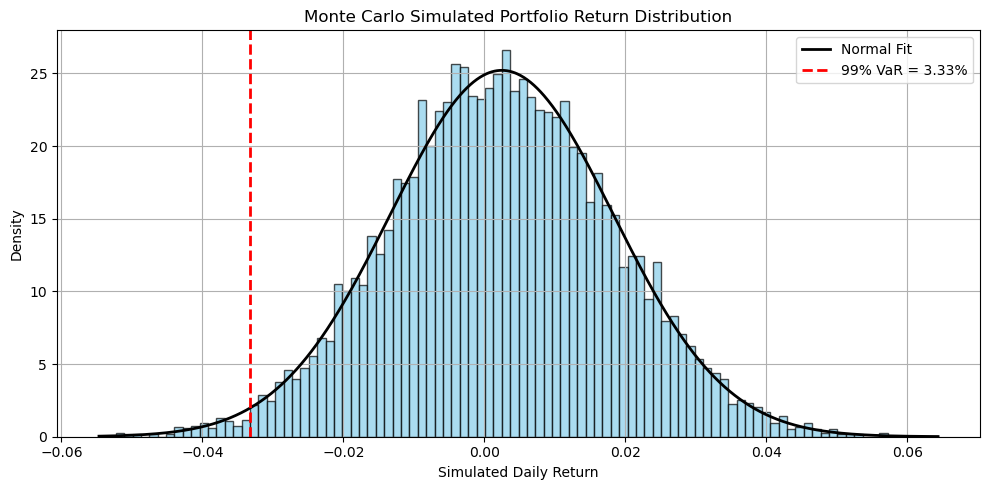

In [13]:
plot_mc_distribution(Port1_MC_VaR_Path, Port1_MC_VaR, confidence=confidence)

In [14]:
Markdown(f"""
### 3.2.3 Output: Simulated Return Distribution

The histogram shows the distribution of 1-day simulated portfolio returns.  
The red dashed line represents the {int(confidence * 100)}% VaR at `{abs(Port1_MC_VaR):.2%}`,  
meaning only {int((1 - confidence) * 100)}% of paths fall below this threshold.  
A normal curve is included for comparison.
""")


### 3.2.3 Output: Simulated Return Distribution

The histogram shows the distribution of 1-day simulated portfolio returns.  
The red dashed line represents the 99% VaR at `3.33%`,  
meaning only 1% of paths fall below this threshold.  
A normal curve is included for comparison.


## 4. Backtesting

## 4.1 Define Backtest Window

Use user-defined test period from config to extract actual portfolio returns for out-of-sample backtesting.

In [15]:
test_start = config["test_start"]
test_end = config["test_end"]
test_prices = get_price_data(tickers, test_start, test_end)
test_returns = Portfolio_R(test_prices, config["weights"])


## 4.2 Define Function: `backtest_VaR()`

Compare actual portfolio returns with simulated VaR.  
Count breach and determine Basel requirement.

Backtesting follows the Basel Committee's traffic-light framework  
(BCBS, "Supervisory framework for backtesting," 1996):

- Green zone (0–4 exceptions): model acceptable  
- Yellow zone (5–9): potential model issues  
- Red zone (10+): model may be rejected

Source: https://www.bis.org/publ/bcbs22.pdf
- `real_returns`: actual portfolio daily return (Series)  
- `VaR`: 1-day VaR threshold (should be negative)

In [16]:
def backtest_VaR(real_returns, VaR):
    violations = real_returns < VaR
    num_violations = violations.sum()
    total_days = len(real_returns)
    violation_rate = num_violations / total_days

    if num_violations <= 4:
        zone = "Green"
    elif num_violations <= 9:
        zone = "Yellow"
    else:
        zone = "Red"

    return {
        "violations": int(num_violations),
        "total": total_days,
        "rate": round(violation_rate, 4),
        "zone": zone
    }

In [17]:
backtest_VaR(test_returns, Port1_MC_VaR)

{'violations': 11, 'total': 249, 'rate': 0.0442, 'zone': 'Red'}

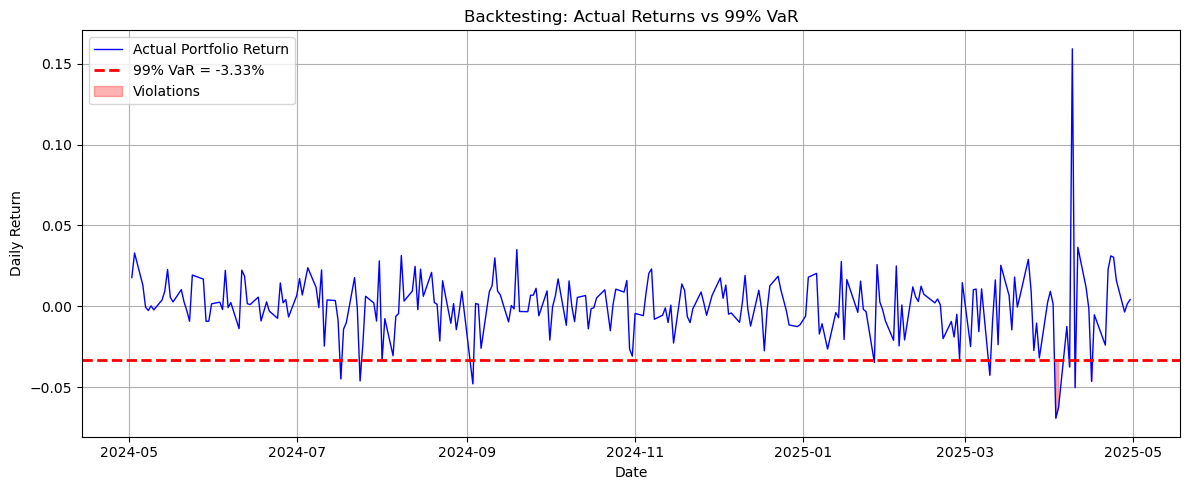

In [18]:
## 4.4 Plot Backtest Result

# Convert to consistent format for plotting
x = test_returns.index
y = test_returns.values.astype("float64")
y2 = np.full_like(y, Port1_MC_VaR)
mask = y < Port1_MC_VaR

# Plot
plt.figure(figsize=(12, 5))
plt.plot(x, y, label="Actual Portfolio Return", color="blue", linewidth=1)
plt.axhline(y=Port1_MC_VaR, color="red", linestyle="--", linewidth=2, label=f"99% VaR = {Port1_MC_VaR:.2%}")
plt.fill_between(x, y, y2, where=mask, color='red', alpha=0.3, label="Violations")

plt.title("Backtesting: Actual Returns vs 99% VaR")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
result = backtest_VaR(test_returns, Port1_MC_VaR)

Markdown(f"""
### 4.5 Output: Backtest Result Summary

- Total backtesting days: **{result['total']}**
- VaR threshold (99%): **{abs(Port1_MC_VaR):.2%}**
- Violations: **{result['violations']}**  
- Violation rate: **{result['rate']:.2%}**

**Basel zone**: `{result['zone']}`  
→ Based on the number of violations, this model falls in the **{result['zone']} zone** under the Basel backtesting framework.
""")


### 4.5 Output: Backtest Result Summary

- Total backtesting days: **249**
- VaR threshold (99%): **3.33%**
- Violations: **11**  
- Violation rate: **4.42%**

**Basel zone**: `Red`  
→ Based on the number of violations, this model falls in the **Red zone** under the Basel backtesting framework.
